In [3]:
library(tidyverse)
library(stargazer)
library(olsrr)
library(readr)
library(readxl)
library(writexl)
library(dplyr)
library(broom)
library(car)
library(lmtest)
library(corpcor)
library(sandwich)
library(fastDummies)
library(plm)
library(forecast)
library(repr)

-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.0     v purrr   1.0.0
v tibble  3.2.1     v dplyr   1.1.1
v tidyr   1.2.1     v stringr 1.5.0
v readr   2.1.3     v forcats 0.5.2
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 



Attaching package: 'olsrr'


The following object is masked from 'package:datasets':

    rivers


Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some


Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.n

In [26]:
options(repr.plot.width=10, repr.plot.height=10)
options(scipen=99)

theme = theme(
  title = element_text(size = 18),
  axis.text.x = element_text(size = 16),
  axis.title.x = element_text(size = 18),
  axis.text.y = element_text(size = 16),
  axis.title.y = element_text(size = 18),
  legend.text = element_text(size= 10)
) 

# 2022 VMT Forecast

In [ ]:
vmt.ann = read_excel('data/WorkingData.xlsx', sheet = 'IN-VMT-clean')[1:30,]
colnames(vmt.ann) = c('year','vmt')

New names:
* `` -> `...1`


In [ ]:
vmt.2022.m = lm(vmt ~ year, vmt.ann)
vmt.2022.m$coefficients[[1]] + vmt.2022.m$coefficients[[2]]*2022

[1] 84391.21

# Income and Gas Correlation

In [7]:
nhts = read.csv('data/vehpub.csv')
nhts2 = nhts[c('HHSTATE','HHFAMINC','BESTMILE')]
nhts.in = nhts2[nhts2$HHSTATE=='IN' | nhts2$BESTMILE != -9,]

In [8]:
incmile = aggregate(BESTMILE ~ HHFAMINC,data=nhts.in,mean)
incmile$Bracket = c('a','b','c','Less than $10,000','$10,000-$14,999','$15,000-$24,999','$25,000-$34,999','$35,000-$49,999','$50,000-$74,999','$75,000-$99,999','$100,000-$124,999','$125,000-$149,999','$150,000-$199,999','$200,000 or more')
incmile = incmile[c('HHFAMINC','Bracket','BESTMILE')][4:14,]
incmile

,HHFAMINC,Bracket,BESTMILE
,<int>,<chr>,<dbl>
4,1,"Less than $10,000",9595.484
5,2,"$10,000-$14,999",9300.401
6,3,"$15,000-$24,999",9230.974
7,4,"$25,000-$34,999",9645.826
8,5,"$35,000-$49,999",10029.380
9,6,"$50,000-$74,999",10407.642
10,7,"$75,000-$99,999",10944.008
11,8,"$100,000-$124,999",11235.182
12,9,"$125,000-$149,999",11557.514


Warning message:
"Removed 3 rows containing missing values (`geom_point()`)."


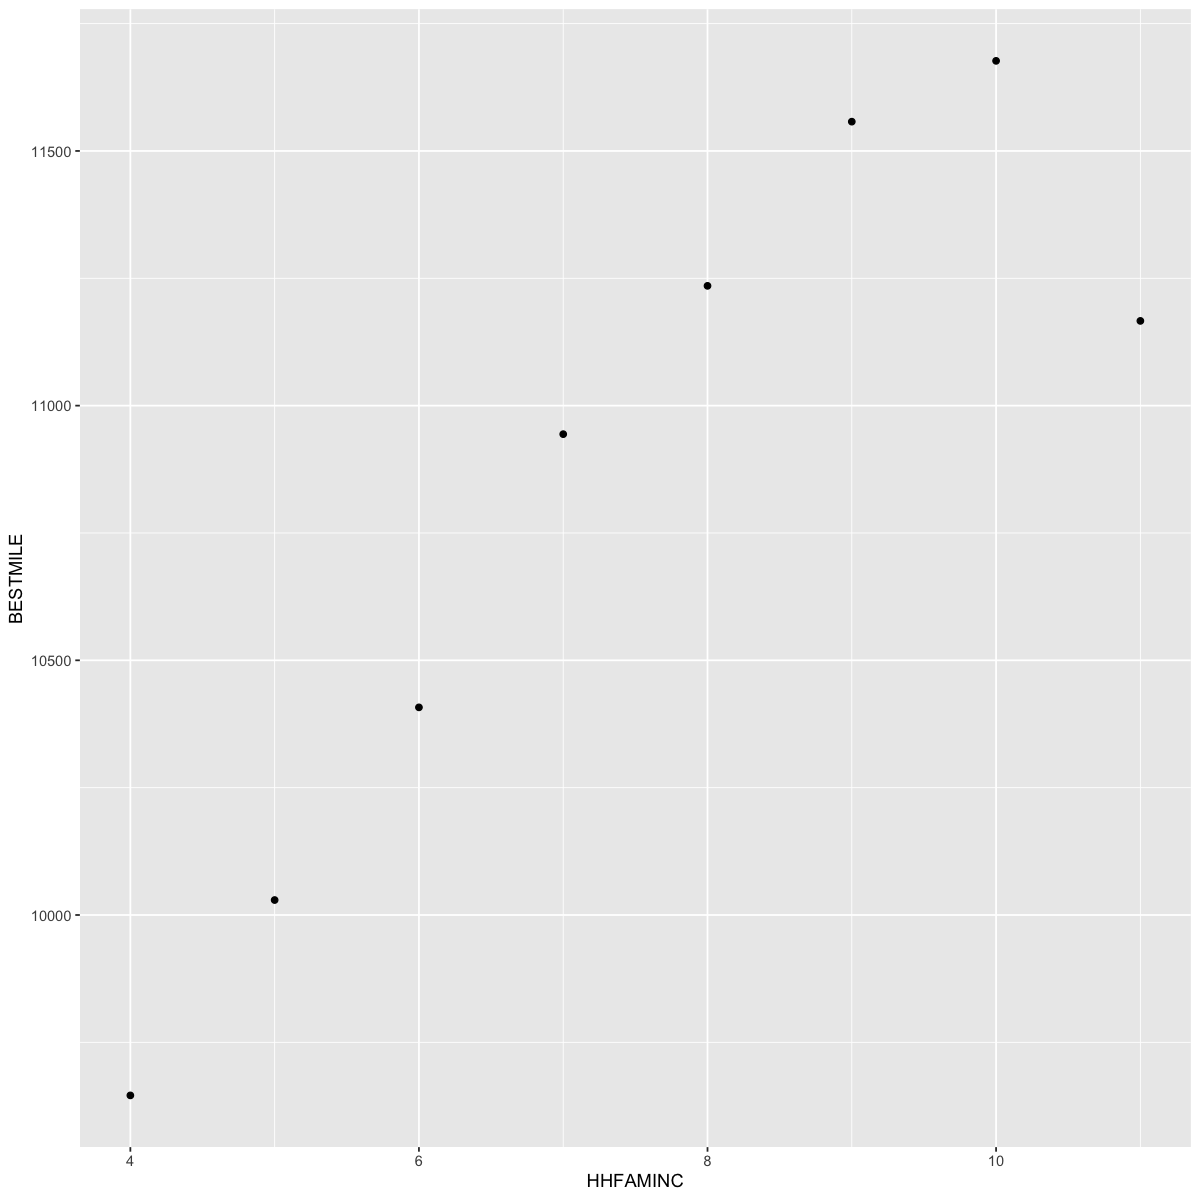

In [9]:
incmile = incmile[c('HHFAMINC','Bracket','BESTMILE')][4:14,]
ggplot(incmile, aes(HHFAMINC,BESTMILE)) + geom_point()

In [10]:
nhts.in$HHFAMINC = as.factor(nhts.in$HHFAMINC)
summary(lm(BESTMILE ~  HHFAMINC, nhts.in))


Call:
lm(formula = BESTMILE ~ HHFAMINC, data = nhts.in)

Residuals:
   Min     1Q Median     3Q    Max 
-11677  -6050  -1972   3238 190769 

Coefficients:
            Estimate Std. Error t value   Pr(>|t|)    
(Intercept)     7746       1738   4.457 0.00000831 ***
HHFAMINC-8      1147       1771   0.648     0.5172    
HHFAMINC-7      1751       1743   1.005     0.3151    
HHFAMINC1       1850       1744   1.061     0.2887    
HHFAMINC2       1555       1742   0.892     0.3723    
HHFAMINC3       1485       1740   0.854     0.3933    
HHFAMINC4       1900       1740   1.092     0.2747    
HHFAMINC5       2284       1739   1.313     0.1891    
HHFAMINC6       2662       1739   1.531     0.1257    
HHFAMINC7       3198       1739   1.839     0.0659 .  
HHFAMINC8       3490       1739   2.007     0.0448 *  
HHFAMINC9       3812       1740   2.191     0.0285 *  
HHFAMINC10      3931       1740   2.260     0.0238 *  
HHFAMINC11      3421       1740   1.966     0.0493 *  
---
Signif. codes: 

# Gas Tax Analysis

## Gas Forecast

### Setup

In [23]:
gas = read_excel('data/WorkingData.xlsx', sheet = 'GasRevMonthly')
gas = dummy_cols(gas, select_columns = c('month','year'))
gas$year = factor(gas$year)
gas$mnth = factor(gas$mnth)
gas$time = index(gas$year)

In [21]:
share.ann = read_excel('data/WorkingData.xlsx', sheet = 'share.ann')
share.m = lm(share ~ I(year^2) + year, share.ann)
reg.m = lm(registered ~ I(year^2) + year, share.ann)
ev.m = lm(ev ~ I(year^2) + year, share.ann)


Call:
lm(formula = ev ~ I(year^2) + year, data = share.ann)

Coefficients:
(Intercept)    I(year^2)         year  
552157408.2        136.3    -548721.5  


In [22]:
share.mnth = read_excel('data/WorkingData.xlsx', sheet = 'share.mnth')
share.mnth$share.hat = share.m$coefficients[[1]] + share.m$coefficients[[2]]*(share.mnth$time^2) + 
    share.m$coefficients[[3]]*share.mnth$time
share.mnth$reg.hat = reg.m$coefficients[[1]] + reg.m$coefficients[[2]]*(share.mnth$time^2) + 
    reg.m$coefficients[[3]]*share.mnth$time
share.mnth$ev.hat = ev.m$coefficients[[1]] + ev.m$coefficients[[2]]*(share.mnth$time^2) + 
    ev.m$coefficients[[3]]*share.mnth$time
# write_xlsx(share.mnth,'data/sharemnth.xlsx')

### Forecast

## Relationship Analysis

In [45]:
names(gas)

[1] "year"            "month"           "mnth"            "key"            
 [5] "avg.vmt.share"   "gas.rev.ann"     "gas.base.ann"    "gas.tax"        
 [9] "gas.base.mnth"   "gas.rev.mnth"    "vmt.ann (mill)"  "vmt.mnth"       
[13] "avg.mpg"         "ev.count"        "month_April"     "month_August"   
[17] "month_December"  "month_February"  "month_January"   "month_July"     
[21] "month_June"      "month_March"     "month_May"       "month_November" 
[25] "month_October"   "month_September" "year_1999"       "year_2000"      
[29] "year_2001"       "year_2002"       "year_2003"       "year_2004"      
[33] "year_2005"       "year_2006"       "year_2007"       "year_2008"      
[37] "year_2009"       "year_2010"       "year_2011"       "year_2012"      
[41] "year_2013"       "year_2014"       "year_2015"       "year_2016"      
[45] "year_2017"       "year_2018"       "year_2019"       "year_2020"      
[49] "year_2021"       "year_2022"       "time"

In [57]:
gas.m = lm(gas.rev.mnth ~  gas.base.mnth + log(gas.tax) + ev.count + mnth + time + year, gas)
summary(gas.m)


Call:
lm(formula = gas.rev.mnth ~ gas.base.mnth + log(gas.tax) + ev.count + 
    mnth + time + year, data = gas)

Residuals:
     Min       1Q   Median       3Q      Max 
-3866706  -282574    -1106   279441  2689350 

Coefficients: (3 not defined because of singularities)
                      Estimate       Std. Error t value             Pr(>|t|)
(Intercept)   -843103194.70240  381422393.72600  -2.210              0.02797
gas.base.mnth          0.22398          0.01357  16.506 < 0.0000000000000002
log(gas.tax)  -434370201.90748  201061033.56036  -2.160              0.03169
ev.count             -92.35053        288.55826  -0.320              0.74920
mnth1           -1296294.21867     690159.85803  -1.878              0.06150
mnth2           -3626300.27871    1186171.63711  -3.057              0.00248
mnth3           -5258190.97177    1748656.44278  -3.007              0.00291
mnth4           -6741127.80465    2317862.68123  -2.908              0.00396
mnth5           -8025036.27835   

In [ ]:
gas.fc = data.frame(matrix(ncol=1,nrow=11*12))
colnames(gas.fc) = c('year')
gas.fc$year = c(2023:2033)
gas.fc$year = gas.fc[order(gas.fc$year),]
gas.fc$mnth = c(1:12)
gas.fc$time = c(289:(288+11*12))
gas.fc = dummy_cols(gas.fc, select_columns = 'mnth')


In [ ]:
gas.fc$gas.hat = (gas.m$coefficients[[1]] + gas.fc$time*gas.m$coefficients[[2]] + gas.fc$mnth_2*gas.m$coefficients[[3]] + 
    gas.fc$mnth_3*gas.m$coefficients[[4]] + gas.fc$mnth_4*gas.m$coefficients[[5]] + gas.fc$mnth_5*gas.m$coefficients[[6]] + 
    gas.fc$mnth_6*gas.m$coefficients[[7]] + gas.fc$mnth_7*gas.m$coefficients[[8]] + gas.fc$mnth_8*gas.m$coefficients[[9]] + 
    gas.fc$mnth_9*gas.m$coefficients[[10]] + gas.fc$mnth_10*gas.m$coefficients[[11]] + gas.fc$mnth_11*gas.m$coefficients[[12]] + 
    gas.fc$mnth_12*gas.m$coefficients[[13]] + mean(gas.m$coefficients[[33]],gas.m$coefficients[[34]],gas.m$coefficients[[35]]))

gas.fc

year,mnth,time,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,gas.hat
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
2023,1,289,1,0,0,0,0,0,0,0,0,0,0,0,78916153
2023,2,290,0,1,0,0,0,0,0,0,0,0,0,0,76525000
2023,3,291,0,0,1,0,0,0,0,0,0,0,0,0,83404616
2023,4,292,0,0,0,1,0,0,0,0,0,0,0,0,82617932
2023,5,293,0,0,0,0,1,0,0,0,0,0,0,0,85429250
2023,6,294,0,0,0,0,0,1,0,0,0,0,0,0,85764884
2023,7,295,0,0,0,0,0,0,1,0,0,0,0,0,87082926
2023,8,296,0,0,0,0,0,0,0,1,0,0,0,0,86730849
2023,9,297,0,0,0,0,0,0,0,0,1,0,0,0,82703222


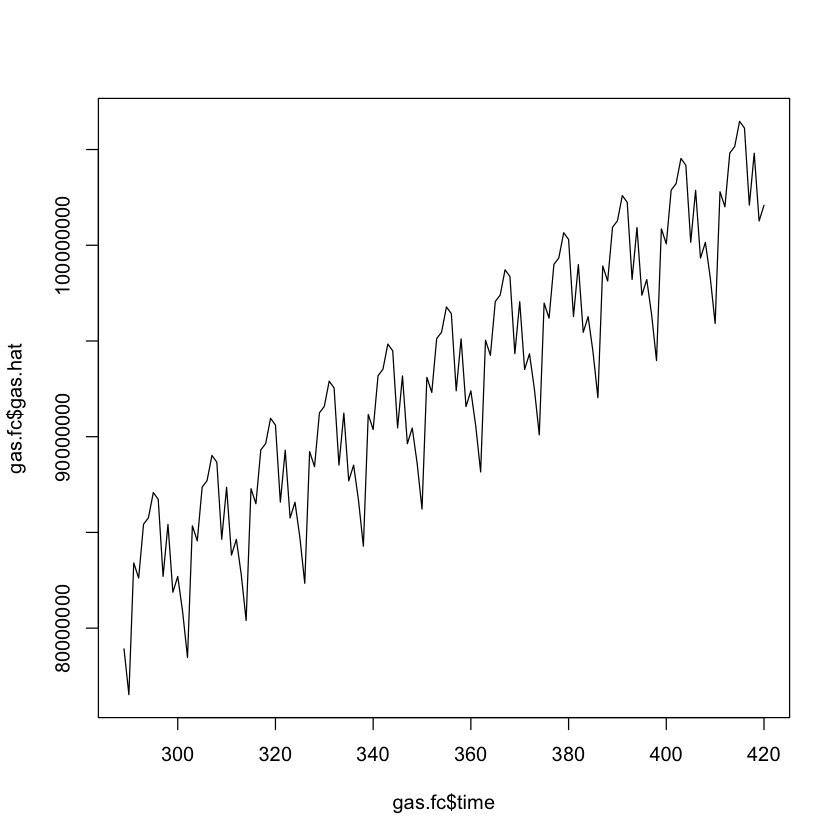

In [ ]:
plot(gas.fc$time,gas.fc$gas.hat, type = "l")

In [ ]:
aggregate(gas.hat ~ year, gas.fc, sum)

year,gas.hat
<int>,<dbl>
2023,999168047
2024,1022435621
2025,1045703194
2026,1068970768
2027,1092238342
2028,1115505915
2029,1138773489
2030,1162041062
2031,1185308636


## Suits Index

In [ ]:
g.suits = nhts[c('HHFAMINC','HHSTATE', 'GSTOTCST')][nhts$HHSTATE == 'IN',]
g.suits = aggregate(GSTOTCST ~ HHFAMINC,g.suits,sum)[4:14,]
g.suits$Bracket = c('Less than $10,000','$10,000-$14,999','$15,000-$24,999','$25,000-$34,999','$35,000-$49,999','$50,000-$74,999','$75,000-$99,999','$100,000-$124,999','$125,000-$149,999','$150,000-$199,999','$200,000 or more')

In [ ]:
g.suits$rate = 0.33
g.suits$burden = g.suits$GSTOTCST * g.suits$rate
g.suits$rawinc = c(10000,4999,9999,9999,14999,24999,24999,24999,24999,49999,49999)
g.suits$shareinc = g.suits$rawinc/sum(g.suits$rawinc)
g.suits$cuminc = g.suits$rawinc[1]/sum(g.suits$rawinc)
g.suits$sharebur = g.suits$burden/sum(g.suits$burden)
g.suits$cumbur = g.suits$burden[1]/sum(g.suits$burden)



In [ ]:
for (row in 2:length(g.suits$HHFAMINC)) {
    g.suits$cuminc[row] = g.suits$shareinc[row] + g.suits$cuminc[row-1]
    g.suits$cumbur[row] = g.suits$sharebur[row] + g.suits$cumbur[row-1]
}


In [ ]:
g.suits = g.suits[c(1:6,8,10)]

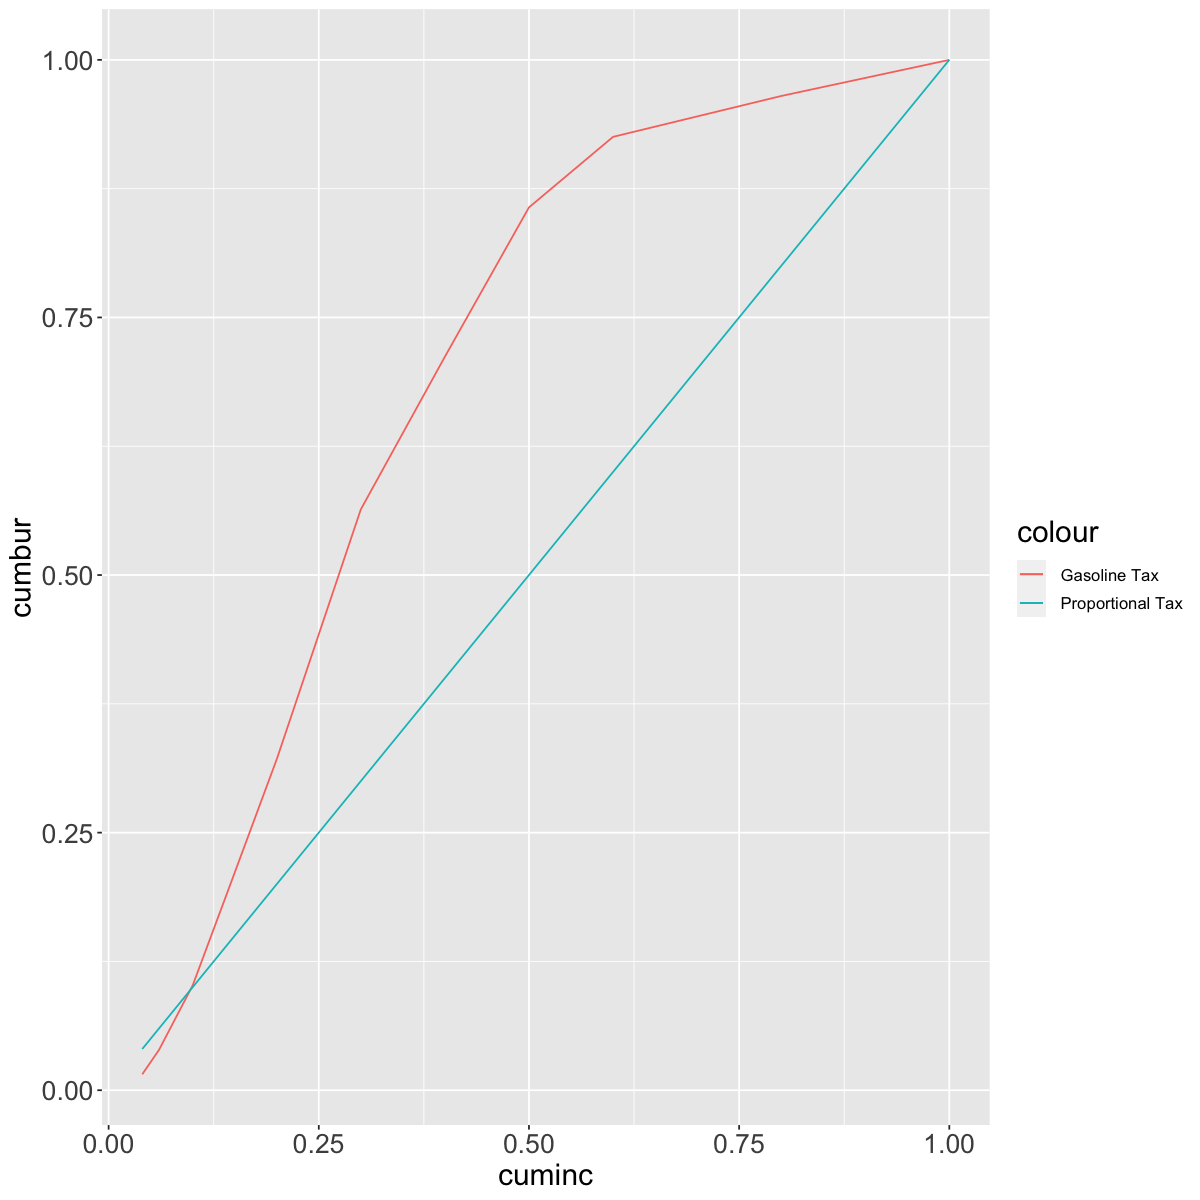

In [ ]:
# x = cumulative income share, y = cumulative tax burden
ggplot(g.suits) + 
    geom_line(aes(cuminc,cumbur, color='Gasoline Tax')) + 
    geom_line(aes(cuminc,cuminc, color='Proportional Tax')) + theme
    

In [ ]:
g.suits$k = (5000/length(g.suits$cumbur))/5000
g.suits$l = (1/2)*(g.suits$cumbur[1])*
    (g.suits$cuminc[1])
for (row in 2:length(g.suits$cumbur)){
    g.suits$l[row] = (1/2)*(g.suits$cumbur[row]+g.suits$cumbur[row-1])*
    (g.suits$cuminc[row]+g.suits$cuminc[row-1])
}

In [ ]:
# Gas Tax Suits
(sum(g.suits$k)-sum(g.suits$l))/sum(g.suits$k)

[1] -4.581222

# VMT Tax Analysis

## VMT Forecast (10 Year)

### Setup

In [61]:
vmt = read_excel('data/WorkingData.xlsx', sheet= 'VmtMonthly')
vmt = dummy_cols(vmt, select_columns = c('mnth','year'))
vmt$year = factor(vmt$year)
vmt$mnth = factor(vmt$mnth)
vmt$time = index(vmt$year)

vmt.fc

### Forecast

In [62]:
names(vmt)

[1] "year"      "month"     "mnth"      "key"       "vmt.mnth"  "mnth_0"   
 [7] "mnth_1"    "mnth_2"    "mnth_3"    "mnth_4"    "mnth_5"    "mnth_6"   
[13] "mnth_7"    "mnth_8"    "mnth_9"    "mnth_10"   "mnth_11"   "year_1999"
[19] "year_2000" "year_2001" "year_2002" "year_2003" "year_2004" "year_2005"
[25] "year_2006" "year_2007" "year_2008" "year_2009" "year_2010" "year_2011"
[31] "year_2012" "year_2013" "year_2014" "year_2015" "year_2016" "year_2017"
[37] "year_2018" "year_2019" "year_2020" "year_2021" "year_2022" "time"

In [67]:
vmt.m = lm(vmt.mnth ~ time + mnth + year, vmt)
data.frame(vmt.m$coefficients)

,vmt.m.coefficients
,<dbl>
(Intercept),5384712187
time,3904803
mnth1,-291483160
mnth2,584799596
mnth3,511289998
mnth4,838745083
mnth5,862063603
mnth6,1019405029
mnth7,981631564
